In [9]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.utils import plot_model

Convolution block - used to perform the primary operation of taking the entered input parameters and processing a double layer of convolution operations. 

In [2]:
def convolution_operation(entered_input, filters=64):
  """Args: entered_input - input to convolution layer
           filters - number of filters, default 64
  """
  # taking first input and implementing the first conv block 
  conv1 = Conv2D(filters, kernel_size=(3,3), padding='same')(entered_input)
  batch_norm1 = BatchNormalization()(conv1)
  act1 = ReLU()(batch_norm1)

  # Taking first input and implementing the second conv block 
  conv2 = Conv2D(filters, kernel_size=(3,3), padding='same')(act1)
  batch_norm2 = BatchNormalization()(conv2)
  act2 = ReLU()(batch_norm2)

  ### 
  # padding = 'same' to maintain the same shapes

  return act2

**Constructing the encoder**
- use consecutive inputs starting from the first layer all the way to the bottom
- will use the convolution_operation (two conv2d layers, 2 batch norms and 2 ReLU activations)
- downsample the response of convolution_operation
- use max pooling 
- return initial output and the max-pooled output (used for performing skip connections)

In [3]:
def encoder(entered_input, filters=64):
  # collect the start and end of each sub-block for normal pass and skip connections
  enc1 = convolution_operation(entered_input, filters)
  MaxPool1 = MaxPooling2D(strides=(2,2))(enc1)
  return enc1, MaxPool1

**Constructing the decoder**
- include three arguments (recieving inputs, input of skip connection, number of filters)
- upsamples the entered input with help of Conv2DTranspose layers 
- concatenate both receiving input and newly upsampled layers and receive value of skip connections
- use combined function and perform convolutional block operation to proceed to next layer and return output value

In [4]:
def decoder(entered_input, skip, filters=64):
  # Upsampling and concatenating the essential features
  Upsample = Conv2DTranspose(filters, (2,2), strides=2, padding='same')(entered_input)
  Connect_Skip = Concatenate()([Upsample, skip])
  out = convolution_operation(Connect_Skip, filters)
  return out

**Constructing the U-Net architecture**
- use the input layer which will contain the respective shapes of our input image
- collect primary outputs and the skip outputs to pass them onto further blocks 
- create the next block and construct the entire decoder architecture until we reach output 
- output will have required dimensions according to our desired output
- call functional API modelling system to create final model and return this model to the user for performing tasks

In [5]:
def U_Net(Image_Size):
  # Take the image size and shape 
  input1 = Input(Image_Size)

  #Construct the encoder blocks 
  skip1, encoder_1 = encoder(input1, 64)
  skip2, encoder_2 = encoder(encoder_1, 64*2)
  skip3, encoder_3 = encoder(encoder_2, 64*4)
  skip4, encoder_4 = encoder(encoder_3, 64*8)

  # Preparing the net block 
  conv_block = convolution_operation(encoder_4, 64*16)

  # construct the decoder blocks
  decoder_1 = decoder(conv_block, skip4, 64*8)
  decoder_2 = decoder(decoder_1, skip3, 64*4)
  decoder_3 = decoder(decoder_2, skip2, 64*2)
  decoder_4 = decoder(decoder_3, skip1, 64)

  out = Conv2D(1, 1, padding='same', activation='sigmoid')(decoder_4)

  model = Model(input1, out)

  return model

**Finalizing the Model:**
- ensure the image shapes are divisilbe by at least 16 or multiples of 16
  - since we are using four max-pooling laters during the down-sampling procedure we dont want to encounter the divisibility of any odd number shapes


In [7]:
input_shape = (160, 160, 3)
model = U_Net(input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 160, 160, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 160, 160, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

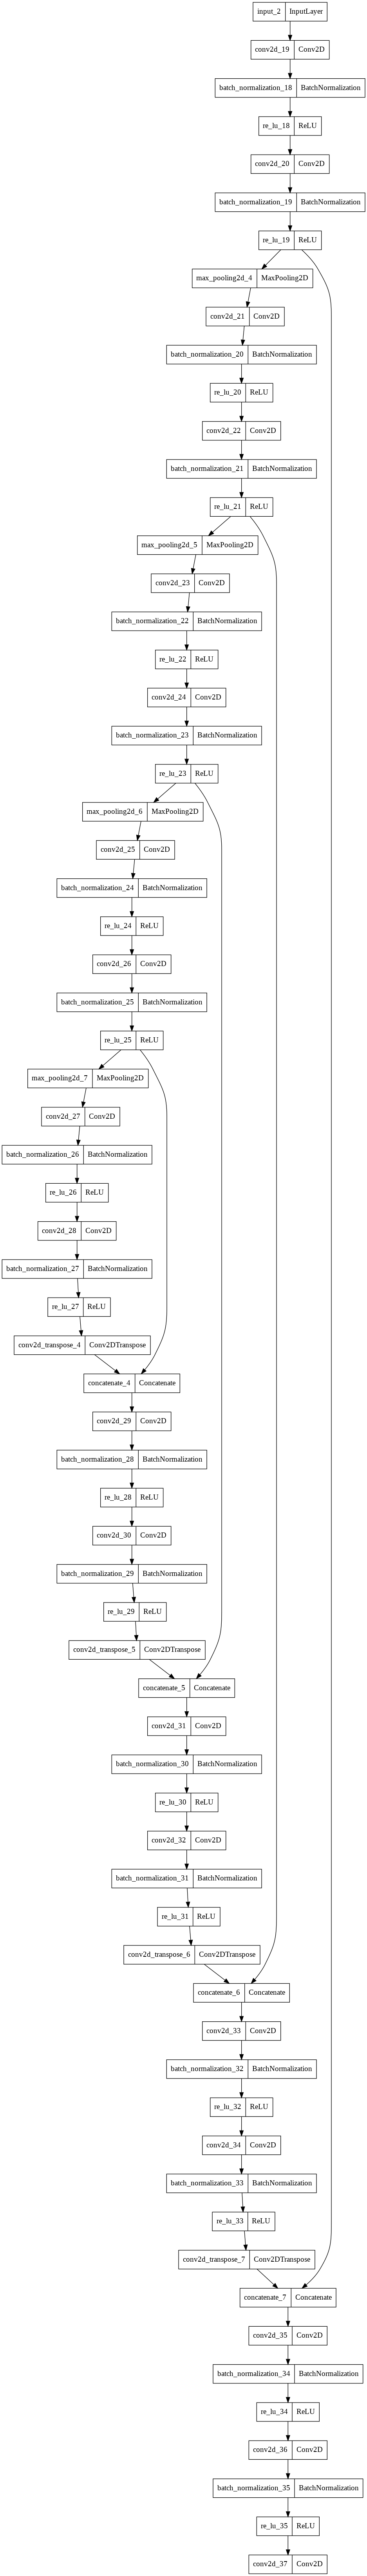

In [10]:
plot_model(model, 'model.png', show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)